<a href="https://colab.research.google.com/github/ivimarkova/Neuromorphic-Anomaly-Detection-for-Epilepsy-seizures/blob/main/EA2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Author: Ivayla Markova**  

**Technical University of Sofia, Bulgaria**

**Subject: Evolutionary Algorithms**

**Topic: Evolutionary Algorithms for Neuromorphic Anomaly Detection**

In this work, I focus on epilepsy, one of the most common neurological disorders affecting over 50 million people globally. Seizures appear as rare abnomal patterns inside EEG signals, which make a neuromorphic anomaly-detection problem.
My approach targets the automatic real-time recognition of seizure events from brain activity.

The Database I used is: https://physionet.org/content/chbmit/1.0.0/


In [ ]:
!pip install pyedflib numpy matplotlib scipy PyWavelets pandas deap


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import pyedflib
from scipy.stats import entropy
import pywt
from sklearn.metrics import classification_report, confusion_matrix
from deap import base, creator, tools, algorithms
import random


In [ ]:
files = ["/chb01_01.edf", "/chb01_02.edf","/chb01_03.edf", "/chb01_04.edf", "/chb01_05.edf","/chb01_06.edf", "/chb01_07.edf"]

seizure_intervals = {
    "/chb01_03.edf": (2996, 3036),
    "/chb01_04.edf": (1467, 1494)
}

fs = 256  # sampling rate
channel = 0

signals = []
labels = []

window_sec = 5
window = window_sec * fs

for file in files:
    f = pyedflib.EdfReader(file)
    signal = f.readSignal(channel)
    f.close()

    sig_len = len(signal)
    num_windows = sig_len // window



    #check if seizures in file
    if file in seizure_intervals: #take the interval
        sz_start,sz_end = seizure_intervals[file]
    else:#no seizures, give data, which will never duplicate
        sz_start,sz_end = -1,-1

    for i in range(num_windows):
        start = i * window
        end = start + window

        t_start = start / fs
        t_end = end / fs

        # Label: 1 = seizure, 0 = normal
        if file in seizure_intervals:
          label=int((t_start>=sz_start and t_end <= sz_end))
        else:
          label=0

        signals.append(signal[start:end])
        labels.append(label)

signals = np.array(signals)
labels = np.array(labels)
print("Windows:", len(signals), "Seizures(label=1):", np.sum(labels), "No seizure windows(label=0):", len(labels) - np.sum(labels), "Balance:{:.1f}% seizures".format(100*np.sum(labels)/len(labels)))


Windows: 5040 Seizures(label=1): 11 No seizure windows(label=0): 5029 Balance:0.2% seizures


In [ ]:
#FEATURE EXTRACTION
def extract_features(sig):
    energy = np.sum(sig ** 2)
    line_length = np.sum(np.abs(np.diff(sig)))
    ent = entropy(np.abs(sig)+1e-6)
    return np.array([energy, line_length, ent])

features = np.array([extract_features(sig) for sig in signals])
print(features.shape)


(5040, 3)


**Evolutionary Algorithm(Feature Weight Optimization)**
Purpose: to optimize weights for anomaly score for each window:

*score = w1.energy+w2.line_lenght+w3.entropy*

Threshold is found automatically based on the selected bias

**RULE FOR CLASSIFICATION**


```
if score > threshold:
 prediction = 1 #seizure
else:
 prediction = 0 #normal
```



In [ ]:
#FULL EA SETUP
#1: Define fitness func
creator.create("FitnessMax", base.Fitness, weights=(1.0,))
creator.create("Individual", list, fitness=creator.FitnessMax)

#2:Create Toolbox
toolbox = base.Toolbox()
#Generate random numbers betw 0 and 1
toolbox.register("attr_float", lambda: random.uniform(0, 1))
#Create individual from 4 genes
toolbox.register("individual", tools.initRepeat, creator.Individual, toolbox.attr_float, 4)
#Create population
toolbox.register("population", tools.initRepeat, list, toolbox.individual)

#3:Fitness function
def evaluate(ind):
    w = np.array(ind[:3])#1st 3 are weights
    thresh = ind[3]#the last is the threshold
#Calculate anomaly score for each window
    scores = features @ w
    preds = (scores > thresh).astype(int)
#Calculate the metrics
    tn, fp, fn, tp = confusion_matrix(labels, preds).ravel()
    sensitivity = tp / (tp + fn + 1e-6)#found seizures
    specificity = tn / (tn + fp + 1e-6)#ignored normal
#fitness - средно аритметично of both
    return (0.5*(sensitivity + specificity),)
#registe fitness func
toolbox.register("evaluate", evaluate)

#4: Genetic operators
toolbox.register("mate", tools.cxBlend, alpha=0.3)#crossover
toolbox.register("mutate", tools.mutGaussian, mu=0, sigma=0.2, indpb=0.5)#Mutation
toolbox.register("select", tools.selTournament, tournsize=3)#Selection

pop = toolbox.population(n=20)
res, log = algorithms.eaSimple(pop, toolbox, cxpb=0.5, mutpb=0.4, ngen=30, verbose=False)

best = tools.selBest(pop, 1)[0]
best


/usr/local/lib/python3.12/dist-packages/deap/creator.py:185: RuntimeWarning: A class named 'FitnessMax' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  warnings.warn("A class named '{0}' has already been created and it "
/usr/local/lib/python3.12/dist-packages/deap/creator.py:185: RuntimeWarning: A class named 'Individual' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  warnings.warn("A class named '{0}' has already been created and it "


[-0.5301601911725281,
 0.09582744554213554,
 0.7271654955072294,
 0.2011053799936498]

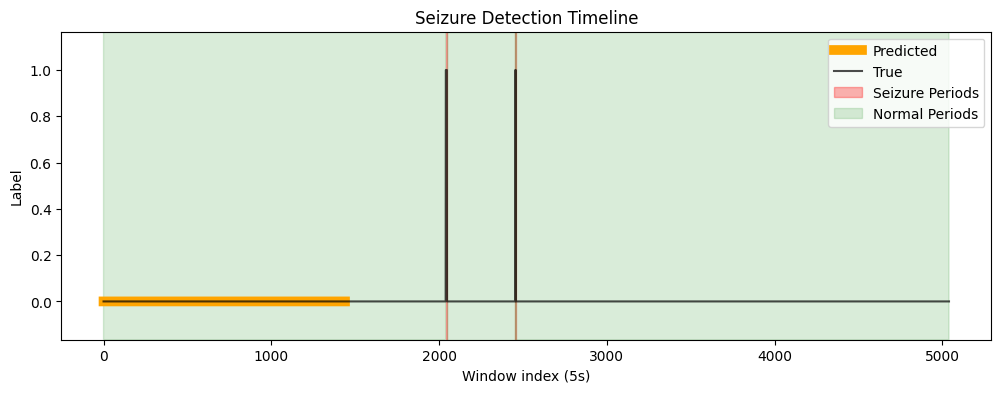

In [ ]:
plt.figure(figsize=(12,4))
plt.plot(preds, label="Predicted", color='orange', alpha=1, linewidth=7)
plt.plot(labels, label="True", color='black', alpha=0.7, linewidth=1.5)#actually happend the seizure in the EEG signals
plt.fill_between(range(len(labels)), 0, 1, where=labels==1, color='red', alpha=0.3, transform=plt.gca().get_xaxis_transform(), label="Seizure Periods")
plt.fill_between(range(len(labels)), 0, 1, where=labels==0, color='green', alpha=0.15, transform=plt.gca().get_xaxis_transform(), label="Normal Periods")
plt.legend()
plt.title("Seizure Detection Timeline")
plt.xlabel("Window index (5s)")
plt.ylabel("Label")
plt.show()
